In [1]:
import numpy as np
import pandas as pd # only used to read the MNIST data set
import networkx as nx
import networkx.algorithms.community as nxcom
import community
from datetime import datetime
import sklearn.tree
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import random
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm
import os
os.path.abspath(os.getcwd())

'/Users/zs18656/Documents/GitHub/whatIsLarva'

In [8]:
def AmazingFunction(l, thing, rule = 'eq'):
    #Gets all indicies subject to rule
    if rule == 'eq':
        return [i for i, x in enumerate(l) if x == thing]
    if rule == 'geq':
        return [i for i, x in enumerate(l) if x >= thing]
    if rule == 'leq':
        return [i for i, x in enumerate(l) if x <= thing]
    else:
        print('add rule ')
        
def GetGroupMatrix(graph, LVs):
    group_matrix = np.zeros(graph.shape)
# gets likelihood matrix for nodes that in the same community from a given LV run
    for LV_i in LVs:
        for comm_i in LV_i:
            nodes = list(comm_i)
            for idx_1 in nodes:
                for idx_2 in nodes:
                    if idx_1 != idx_2:
                        group_matrix[idx_1][idx_2] += 1
    group_matrix = group_matrix/len(LVs)
    return group_matrix

def GetThreshMatrix(group_matrix, threshold): 
    # gets adjacency matrix for nodes that are of threshold likelihood of being in the same community
#     E.g. if thresh is 1, then the thresh matrix will connect node i and j IF they are always found to be in 
# the same community across all LV runs
    thresh_matrix = group_matrix.copy()
    thresh_matrix[thresh_matrix >= threshold] = 1
    thresh_matrix[thresh_matrix < threshold] = 0
    return thresh_matrix
def GetSubGraphs(thresh_matrix):
# gets all subgrahs of the threshold matrix. This finds the communities subject to the threshold matrix
# big threshold will make communities larger, so fewer subgraphs
    graph = nx.from_numpy_array(thresh_matrix)
    # Get a list of subgraphs (smaller networks)
    subgraphs = list(nx.connected_components(graph))
    subgraph_sizes = [len(x) for x in subgraphs]

    zipped = list(zip(subgraphs, subgraph_sizes))
    zipped.sort(key=lambda x: -x[1])
    return zipped #returns the subgraph node idxs, but also the size of the subgraph, sorted.

In [9]:
fly_mat = pd.read_csv('science.add9330_data_s1_to_s4/Supplementary-Data-S1/all-all_connectivity_matrix.csv').drop(columns=['Unnamed: 0'])
fly_mat = fly_mat.to_numpy()
# Convert fly matrix into binary adjacency matrix
fly_mat[fly_mat > 0] = 1
fly_mat[fly_mat != 1] = 0
fly_mat[np.identity(fly_mat.shape[0], dtype=bool)] = 0.
fly_graph = fly_mat
# Make random graph
rand_graph = nx.fast_gnp_random_graph(fly_graph.shape[0], np.sum(fly_graph) / (fly_graph.shape[0] ** 2))
rand_graph = nx.to_numpy_array(rand_graph)
# remove self recurrent connections
rand_graph[np.identity(rand_graph.shape[0], dtype=bool)] = 0.

In [10]:
print('fly density: ', np.sum(fly_mat.reshape(-1))/(fly_mat.shape[0]*fly_mat.shape[1]))
print('ran density: ', np.sum(rand_graph.reshape(-1))/(rand_graph.shape[0]*rand_graph.shape[1]))
print(f"Fly graph {np.sum(fly_graph)} edges, rand graph {np.sum(rand_graph)} edges")

fly density:  0.012638989872283547
ran density:  0.012573809681186243
Fly graph 110140.0 edges, rand graph 109572.0 edges


In [11]:
fly_graph

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
N= 20

In [13]:
G_fly = nx.from_numpy_array(fly_graph)
LVs_fly = [nx.community.louvain_communities(G_fly) for i in range(N)]
G_ran = nx.from_numpy_array(rand_graph)
LVs_ran = [nx.community.louvain_communities(G_ran) for i in range(N)]

In [14]:
for i in range(N):
    print([len(x) for x in LVs_fly[i]])
    print([len(x) for x in LVs_ran[i]])

[486, 460, 231, 410, 496, 143, 390, 336]
[339, 547, 164, 202, 483, 293, 483, 441]
[411, 232, 66, 442, 381, 483, 531, 330, 76]
[92, 150, 500, 505, 352, 433, 115, 298, 507]
[64, 427, 337, 232, 446, 511, 343, 510, 82]
[408, 448, 42, 339, 99, 513, 76, 319, 320, 388]
[557, 587, 85, 447, 311, 520, 445]
[440, 318, 234, 465, 543, 276, 158, 518]
[388, 479, 450, 311, 350, 511, 77, 386]
[224, 390, 295, 475, 297, 480, 298, 169, 324]
[462, 500, 575, 374, 311, 171, 145, 414]
[491, 384, 361, 411, 380, 305, 316, 304]
[62, 485, 296, 452, 76, 372, 374, 496, 339]
[392, 399, 30, 401, 349, 336, 320, 327, 398]
[459, 315, 387, 398, 482, 498, 72, 341]
[257, 186, 246, 270, 402, 453, 420, 164, 554]
[228, 62, 485, 384, 440, 342, 566, 368, 77]
[186, 367, 114, 356, 141, 444, 238, 80, 307, 86, 317, 316]
[422, 123, 426, 483, 472, 510, 353, 163]
[186, 476, 369, 224, 216, 112, 375, 517, 204, 273]
[67, 510, 475, 235, 734, 456, 43, 432]
[252, 444, 403, 125, 253, 330, 52, 512, 529, 52]
[492, 437, 391, 225, 525, 404, 147,

In [15]:
group_matrix_fly = GetGroupMatrix(fly_graph ,LVs_fly)
group_matrix_ran = GetGroupMatrix(rand_graph ,LVs_ran)

In [16]:
thresh = 1
thresh_matrix_fly = GetThreshMatrix(group_matrix_fly, thresh)
thresh_matrix_ran = GetThreshMatrix(group_matrix_ran, thresh)

subgraphs_fly = GetSubGraphs(thresh_matrix_fly)
subgraphs_ran = GetSubGraphs(thresh_matrix_ran)

len(subgraphs_fly), len(subgraphs_ran)

(422, 2952)

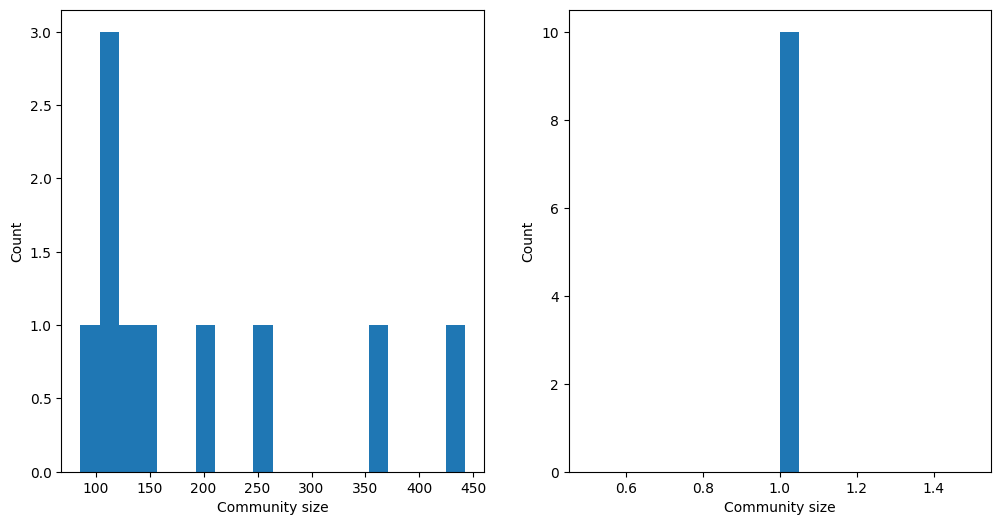

In [17]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
sorted_sizes = [x[1] for x in subgraphs_fly]
ax[0].hist(sorted_sizes[:10], bins = 20)
sorted_sizes = [x[1] for x in subgraphs_ran]
ax[1].hist(sorted_sizes[:10], bins = 20)

ax[0].set_ylabel('Count')
ax[0].set_xlabel('Community size')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Community size')



plt.show()

In [ ]:
from reservoirs import Reservoir
# initilise learning algorithm, this can be changed later
model = RandomForestRegressor
model_kwargs = {"n_estimators":100, "verbose":0, "n_jobs":6, "max_depth":5}
model_name = str(model).split('.')[-1].split("'")[0]
# Initialise reservoirs
fly_res = Reservoir(fly_graph, prediction_model=model, prediction_model_kwargs=model_kwargs)



In [58]:
min_com_length = 10
node_community_list = []
for idx, i in enumerate(subgraphs_fly):
    com_ID, nodes = idx, [x for x in list(i[0])]
    if len(nodes) < min_com_length:
        com_ID = -1
    for node_id in nodes:
        node_community_list.append([node_id, com_ID])
        
node_community_list.sort(key=lambda x: x[0])
node_community_list[:10]

[[0, 7],
 [1, 7],
 [2, 7],
 [3, 5],
 [4, 3],
 [5, 3],
 [6, 3],
 [7, -1],
 [8, 5],
 [9, 5]]

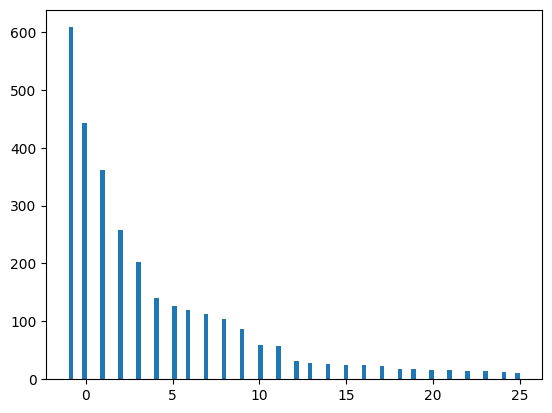

In [62]:
plt.hist([x[1] for x in node_community_list], bins = 100)
plt.show()

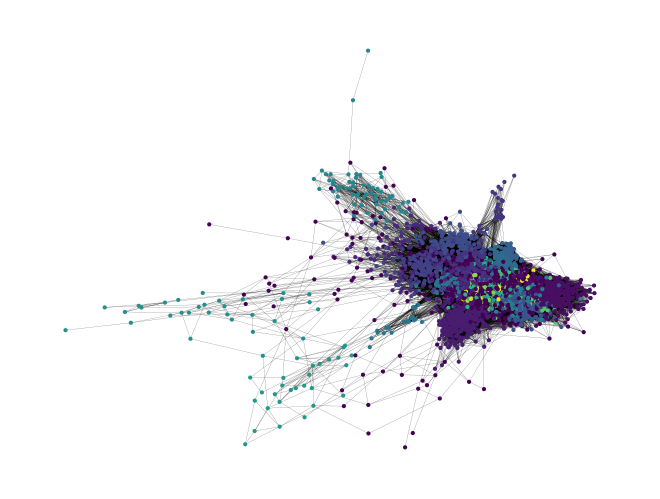

In [63]:
nx.draw(G_fly, node_size = 4, width = 0.1, node_color = [x[1] for x in node_community_list])